In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import mlccd_models
import datetime
import os

# deactivate GPU on ragnarok
# tf.config.set_visible_devices([], "GPU")

2024-10-28 00:35:29.626109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 00:35:29.633128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 00:35:29.646285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 00:35:29.650216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 00:35:29.663076: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Load the training and test data
data_tritium = mlccd_models.CCDData(
    # os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_H3_5000000.h5"),
    os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/tritium_10_17_add_classical_disc_add_BDT.h5"),
    # os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-26-tritium-and-gamma-evenly-distributed/diffused_H3_5000000.h5"),
    image_unit="keV"
)
data_gamma = mlccd_models.CCDData(
    # os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_gamma_20000000.h5"),
    os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/gamma_10_17_add_classical_disc_add_BDT.h5"),
    # os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-26-tritium-and-gamma-evenly-distributed/diffused_gamma_20000000.h5"),
    image_unit="keV"
)
data_gamma.plot(title="Gamma", num_plots=36)
data_tritium.plot(title="Tritium", num_plots=36)

In [4]:
# Combine the two datasets
ccd_data = 1 * data_gamma + 1 * data_tritium
# Clip the data between thresholds and normalize to 0-1
ccd_data.normalize(threshold_low=0, threshold_high=20)
# Divide the data into training, test, and validation sets
ccd_data.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

In [4]:
loss_function = "binary_crossentropy"
loss_function = "mean_squared_error"
pinch_size = 6
kl_loss_weight = 0.0
l1_weight = 0
mse_scaler = 5000
config = {
    "model_name": f'autoencoder_{datetime.datetime.now().strftime("%Y%m%d_%H%M")}',
    "learning_rate": 0.001,
    "architecture": "autoencoder",
    "dataset": ccd_data.file_path,
    "epochs": 4,
    "batch_size": 256,
    "loss_function": loss_function,
    "threshold_high": ccd_data.threshold_high,
    "threshold_low": ccd_data.threshold_low,
    "data_filename": ccd_data.file_path,
    "pinch_size": pinch_size,
    "kl_loss_weight": kl_loss_weight,
    "l1_weight": l1_weight,
    "padding": "same",
    "mse_scaler": mse_scaler,
}

In [5]:
# Create the model
model = mlccd_models.VAEModel(
    ccd_data.IMAGE_WIDTH,
    ccd_data.IMAGE_HEIGHT,
    ccd_data.IMAGE_CHANNELS,
    pinch_size=config["pinch_size"],
    kl_loss_weight=config["kl_loss_weight"],
    l1_weight=config["l1_weight"],
    padding=config["padding"],
    mse_scaler=config["mse_scaler"],
)

adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=config["learning_rate"]
)

model.compile(optimizer=adam_optimizer, loss=config["loss_function"])

I0000 00:00:1730100935.504903    7954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730100935.525157    7954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730100935.525192    7954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730100935.527076    7954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730100935.527106    7954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
mlccd_models.train(model=model, config=config, ccd_data=ccd_data, offline=True)

Epoch 1/4


I0000 00:00:1730100937.914827    8115 service.cc:146] XLA service 0x7f1f5400fe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730100937.914849    8115 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-28 00:35:37.939106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 00:35:38.101631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 126/5812 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - kl_loss: 0.0109 - l1_loss: 815.6747 - loss: 3.0777 - reconstruction_loss: 3.0717

I0000 00:00:1730100939.363890    8115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5812/5812 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - kl_loss: 0.0499 - l1_loss: 926.0186 - loss: 1.9870 - reconstruction_loss: 1.9621 - val_loss: 2.0316 - val_reconstruction_loss: 1.9981 - val_kl_loss: 0.0669
Epoch 2/4
5812/5812 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - kl_loss: 0.0624 - l1_loss: 965.4478 - loss: 1.9357 - reconstruction_loss: 1.9045 - val_loss: 2.0184 - val_reconstruction_loss: 1.9831 - val_kl_loss: 0.0706
Epoch 3/4
5812/5812 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - kl_loss: 0.0635 - l1_loss: 1006.8143 - loss: 1.9463 - reconstruction_loss: 1.9146 - val_loss: 2.0140 - val_reconstruction_loss: 1.9756 - val_kl_loss: 0.0767
Epoch 4/4
5812/5812 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - kl_loss: 0.0646 - l1_loss: 1070.0013 - loss: 2.0479 - reconstruction_loss: 2.0156 - val_loss: 2.1038 - val_reconstruction_loss: 2.0690 - val_kl_loss: 0.0696


### Try visualize latent space

W0000 00:00:1730100977.225527    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.241377    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.249227    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.282983    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.324521    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.349673    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.376692    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.389638    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100977.414311    7954 gp

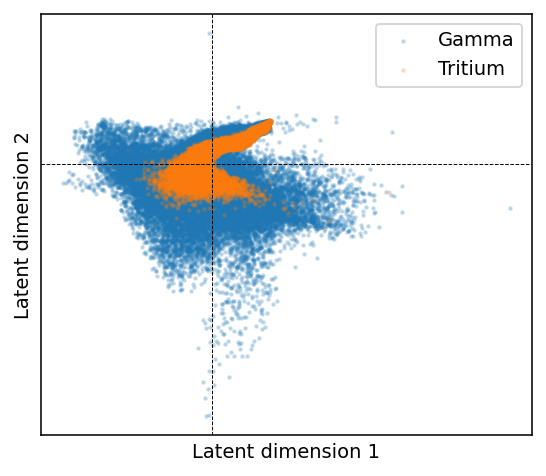

In [7]:
num_to_plot = 100000
encoded_train = model.encode(ccd_data.x_train[:num_to_plot])
encoded_train.shape

# Center the data
centered_encoded_train = encoded_train# - encoded_train.mean(axis=0)

plt.figure(figsize=(4, 3.5), dpi=140)
plt.scatter(centered_encoded_train[ccd_data.y_train[:num_to_plot]==0, 0], 
            centered_encoded_train[ccd_data.y_train[:num_to_plot]==0, 1], 
            s=2, alpha=0.2, label="Gamma")
plt.scatter(centered_encoded_train[ccd_data.y_train[:num_to_plot]==1, 0], 
            centered_encoded_train[ccd_data.y_train[:num_to_plot]==1, 1], 
            s=2, alpha=0.2, label="Tritium")
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
# plt.xlim(-0.0005, 0.0005)
# plt.ylim(-0.0005, 0.0005)
plt.legend()
# plt.title("Centered Latent Space Visualization")
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
# remove tick labels

# plt.xticks([])
# plt.yticks([])
plt.tight_layout()


In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
num_to_plot = 10000
encoded_train = model.encode(ccd_data.x_train[:num_to_plot])
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(encoded_train)


W0000 00:00:1730100978.310571    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.311431    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.312080    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.314517    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.318820    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.321076    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.323605    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.325017    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100978.327250    7954 gp

In [9]:
from umap import UMAP
encoded_train = model.encode(ccd_data.x_train[:num_to_plot])

# UMAP
umap = UMAP(n_components=2)
umap_data = umap.fit_transform(encoded_train)





ModuleNotFoundError: No module named 'umap'

In [10]:

# UMAP plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=140)
tritium_umap = umap_data[ccd_data.y_train[:num_to_plot] == 1]
gamma_umap = umap_data[ccd_data.y_train[:num_to_plot] == 0]
ax.scatter(gamma_umap[:, 0], gamma_umap[:, 1], s=0.5, label="Gamma", alpha=0.7, zorder=10)
ax.scatter(tritium_umap[:, 0], tritium_umap[:, 1], s=0.5, label="Tritium", alpha=0.7, zorder=0)
ax.set_title("UMAP Visualization")
ax.legend()

In [11]:
tritium_tsne = tsne_data[ccd_data.y_train[:num_to_plot] == 1]
gamma_tsne = tsne_data[ccd_data.y_train[:num_to_plot] == 0]

plt.scatter(gamma_tsne[:, 0], gamma_tsne[:, 1], s=0.5, label="Gamma")
plt.scatter(tritium_tsne[:, 0], tritium_tsne[:, 1], s=0.5, label="Tritium")
plt.legend()

In [12]:
_ = plt.hist(np.unique(model.predict_mahalanobis(ccd_data.x_test[ccd_data.y_test == 1])), label="Euclid, tritium")
_ = plt.hist(np.unique(model.predict_mahalanobis(ccd_data.x_test[ccd_data.y_test == 0])), label="Euclid, gamma", alpha=0.5)
_ = plt.legend()


W0000 00:00:1730100999.720793    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100999.756579    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100999.788887    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


W0000 00:00:1730100999.941683    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100999.974431    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730100999.991952    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101000.011095    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101000.021569    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101000.039729    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101000.055103    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101000.065935    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101000.071912    7954 gp

In [13]:
# bins = np.linspace(0, 3, 100)
encoded_tritium = model.encode(ccd_data.x_test[ccd_data.y_test == 1])
encoded_gamma = model.encode(ccd_data.x_test[ccd_data.y_test == 0])
# _ = plt.hist(np.exp(-np.linalg.norm(encoded_tritium, axis=1)), bins=bins, label="Euclid, tritium")
# _ = plt.hist(np.exp(-np.linalg.norm(encoded_gamma, axis=1)), bins=bins, label="Euclid, gamma", alpha=0.5)
_ = plt.hist(np.linalg.norm(encoded_tritium, axis=1), label="Euclid, tritium")
_ = plt.hist(np.linalg.norm(encoded_gamma, axis=1), label="Euclid, gamma", alpha=0.5)
_ = plt.legend()


### Evaluation plots

In [14]:
test_predictions = model.predict(ccd_data.x_test)
test_predictions_euclid = model.predict_euclidean(ccd_data.x_test)
test_predictions_mahalanobis = model.predict_mahalanobis(ccd_data.x_test)
test_predictions_log_likelihood = model.predict_log_likelihood(ccd_data.x_test)
classical_discriminator_scores = ccd_data.tracks_metadata.iloc[ccd_data.test_indices].classicalDiscriminatorS


max_mcc, optimal_threshold = (
    mlccd_models.scan_mcc(
        ccd_data.y_test, test_predictions
    )
)
_ = mlccd_models.plot_confusion_matrix(
    ccd_data.y_test, test_predictions, threshold=0.5
)

W0000 00:00:1730101005.420142    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.427405    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.431766    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.511855    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.639155    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.707484    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.750927    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.773333    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101005.812231    7954 gp

In [16]:
predictions_all = model.predict(ccd_data.images)


2024-10-28 00:37:14.395354: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
W0000 00:00:1730101034.398922    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101034.417095    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101034.428779    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101034.638763    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101036.824200    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101037.000091    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be redu

ResourceExhaustedError: Exception encountered when calling UpSampling2D.call().

[1m{{function_node __wrapped__Tile_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[2125415,10,5,2,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile][0m

Arguments received by UpSampling2D.call():
  • inputs=tf.Tensor(shape=(2125415, 5, 5, 16), dtype=float32)

In [20]:
# Predict in batches to avoid memory issues
batch_size = 5000
num_samples = len(ccd_data.images)
predictions_all = []

for i in range(0, num_samples, batch_size):
    batch_end = min(i + batch_size, num_samples)
    batch_predictions = model.predict(ccd_data.images[i:batch_end])
    predictions_all.append(batch_predictions)

# Concatenate all predictions
predictions_all = np.concatenate(predictions_all)

W0000 00:00:1730101203.348933    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.350777    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.352035    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.356603    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.364034    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.368406    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.373255    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.376091    7954 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730101203.380468    7954 gp

In [21]:

ccd_data.tracks_metadata['prediction_autoencoder'] = predictions_all.flatten()

In [22]:
ccd_data.write(os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/both_incl_auto"))


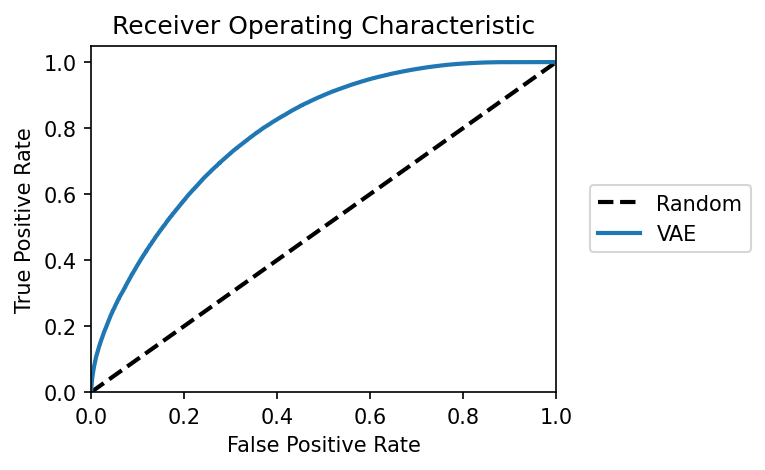

In [17]:

fig, ax = mlccd_models.plot_roc_curve(ccd_data.y_test, test_predictions, label="VAE")

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

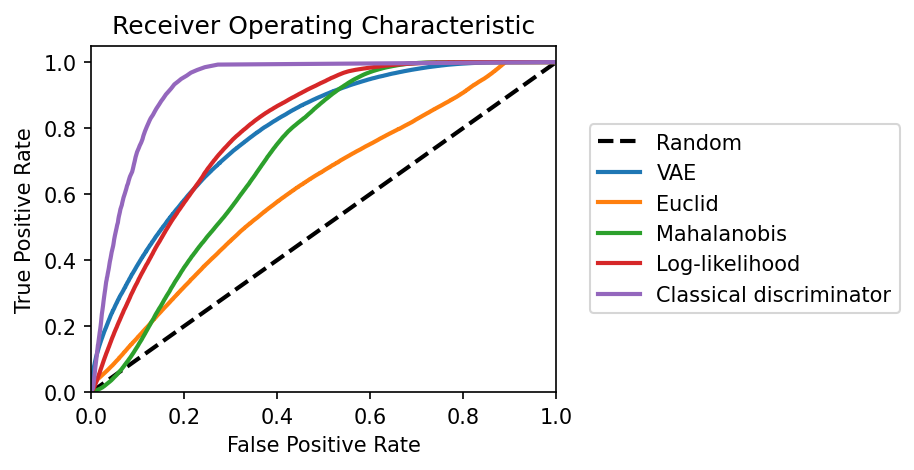

In [18]:
fig, ax = mlccd_models.plot_roc_curve(ccd_data.y_test, test_predictions, label="VAE")
mlccd_models.plot_roc_curve(ccd_data.y_test, test_predictions_euclid, ax=ax, label="Euclid")
mlccd_models.plot_roc_curve(ccd_data.y_test, test_predictions_mahalanobis, ax=ax, label="Mahalanobis")
mlccd_models.plot_roc_curve(ccd_data.y_test, test_predictions_log_likelihood, ax=ax, label="Log-likelihood")
mlccd_models.plot_roc_curve(ccd_data.y_test, classical_discriminator_scores, ax=ax, label="Classical discriminator")


In [19]:
mda, threshold_mda_optimal = mlccd_models.scan_mda(ccd_data.y_test, test_predictions, plot=True)
mda, threshold_mda_optimal = mlccd_models.scan_mda(ccd_data.y_test, test_predictions_log_likelihood, plot=True)
print(f"Threshold: {threshold_mda_optimal}, MDA: {mda}")

Threshold: 5798786746.078998, MDA: 0.010497505062065069


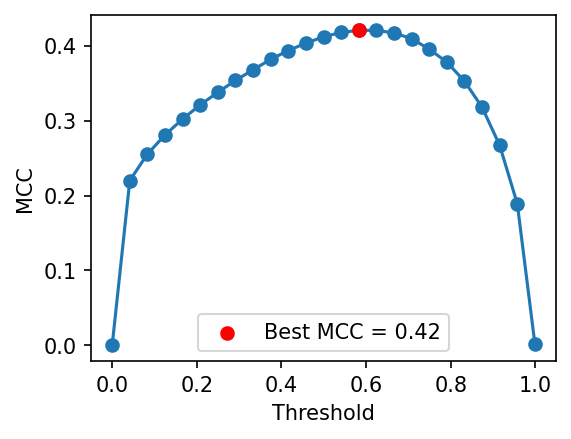

Threshold: 0.5827380120754243, MCC: 0.42061099179759576


In [19]:
mda, threshold_mcc_optimal = mlccd_models.scan_mcc(ccd_data.y_test, test_predictions, plot=True)
print(f"Threshold: {threshold_mcc_optimal}, MCC: {mda}")


In [20]:
threshold_mda_optimal

0.6659862995147706

In [59]:
fig, ax = mlccd_models.plot_scores(ccd_data.y_test, test_predictions_mahalanobis, threshold_mda_optimal=threshold_mda_optimal_mahalanobis)

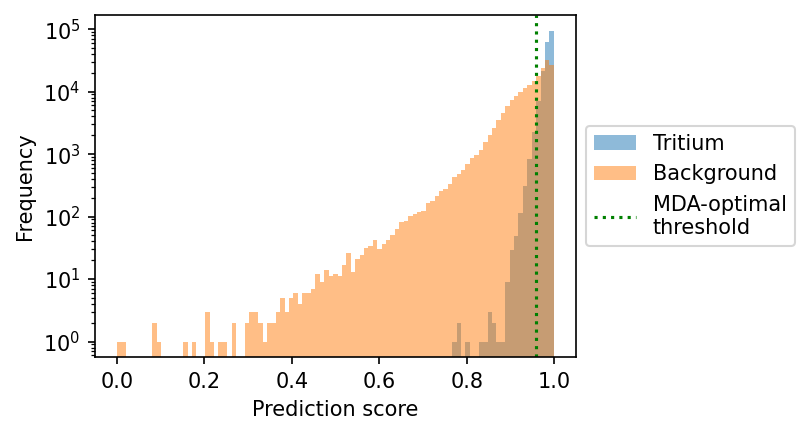

In [60]:
fig, ax = mlccd_models.plot_scores(ccd_data.y_test, test_predictions, threshold_mda_optimal=threshold_mda_optimal)

In [23]:
fig, ax = mlccd_models.plot_scores(ccd_data.y_test, classical_discriminator_scores, threshold_mcc_optimal=threshold_mcc_optimal, threshold_mda_optimal=threshold_mda_optimal)

NameError: name 'classical_discriminator_scores' is not defined

# Look at extremes}

In [24]:
_ = mlccd_models.plot_prediction_grid(ccd_data, np.array(classical_discriminator_scores), low_threshold=0.1, high_threshold=0.75, vmin=0, vmax=0.07)


NameError: name 'classical_discriminator_scores' is not defined

In [ ]:
y_pred = model.predict(ccd_data.x_test)
_ = mlccd_models.plot_prediction_grid(ccd_data, y_pred, low_threshold=0.1, high_threshold=0.75, vmin=0, vmax=0.07)


In [61]:
predictions_all = model.predict(ccd_data.images)
ccd_data.tracks_metadata['prediction'] = predictions_all.flatten()

Text(0, 0.5, 'Prediction score')

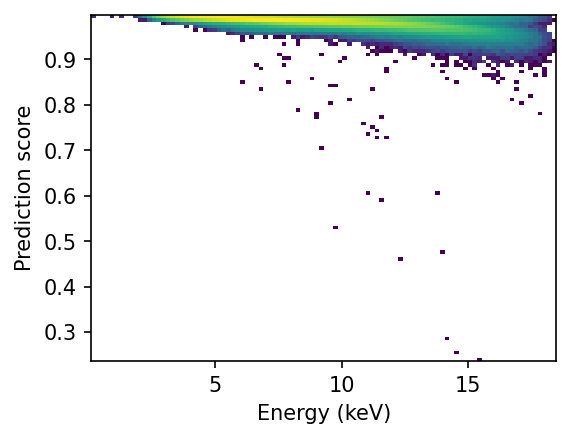

In [62]:
from matplotlib.colors import LogNorm

energy = ccd_data.tracks_metadata.query('primaryKind != 22').energyPrimaryKeV.values
scores = ccd_data.tracks_metadata.query('primaryKind != 22').prediction.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
_ = ax.hist2d(energy, scores, bins=100, norm=LogNorm())
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Prediction score')
# plt.colorbar()

### Show energy of tritium that are FN, TP

# Draw image of model

/home/emil/miniconda3/envs/mlccd/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


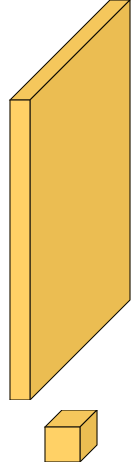

In [160]:
# !wget https://github.com/kavin808/arial.ttf/raw/master/arial.ttf
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype(
    "../fonts/arial.ttf", 32
)  # using comic sans is strictly prohibited!
scaler = 1.5

visualkeras.layered_view(
    model.decoder,
    legend=True,
    font=font,
    scale_z=2 * scaler,
    max_z=150 * scaler,
    scale_xy=20 * scaler,
)